In [1]:
basenames="""254397_1 A1-3a_ASAP
254403_1 E1-2_ASAP
254415_56 A2-4a_ASAP
254430_13 A2$4_ASAP
254531_38 A2$4_ASAP
254533_38 A2$4_ASAP
254538_38 A1$3_ASAP
254906_1 F1$2_ASAP
255571_56 A1-3b_ASAP
""".splitlines()

In [2]:
import glob
tifs={f[f.rfind("/")+1:f.rfind('.')]:f for f in glob.glob("../../images/melanoma/*")}

In [3]:
from PIL import Image
Image.MAX_IMAGE_PIXELS = None
import skimage.io
import skimage
import cv2
import tifffile as tiff 
import numpy as np
import tifffile as tiff
import xmltodict as xd, numpy as np, pickle
from collections import defaultdict
import pandas as pd
import matplotlib, matplotlib.pyplot as plt
matplotlib.rcParams['figure.dpi']=300
import seaborn as sns
get_file=lambda basename:f"xml/{basename}.xml"
get_tif=lambda basename:tifs[basename[7:]]

In [67]:
i=8
basename=basenames[i]
xml=get_file(basename)
tif=get_tif(basename)


In [2]:
! df .

Filesystem                                                                      1K-blocks        Used  Available Use% Mounted on
dartfs-nfs-t4.dartmouth.edu:/ifs/rc/dartfs/rc/lab/V/VaickusL_slow/users/jlevy 37580963840 33285979136 4294984704  89% /dartfs/rc/lab/V/VaickusL_slow/users/jlevy


In [68]:
compression=8

with open(xml,"rb") as f:
    d=xd.parse(f)
    
cells=[]
cell_dot=[]
lbls=[]
for i,annotation in enumerate(d['ASAP_Annotations']["Annotations"]["Annotation"]):
#     print(annotation["@PartOfGroup"])
#     print(annotation)
#     break
#     if annotation["@PartOfGroup"]=="nuc":
#     if annotation["@Type"]=="Dot":
#         cell_dot.append(np.array((float(annotation["Coordinates"]["Coordinate"]["@X"]),float(annotation["Coordinates"]["Coordinate"]["@Y"]))))
#     elif annotation["@Type"] in ["Spline",""]:
    try:
        lbl=annotation["@PartOfGroup"]
        contour=np.array([(float(coord["@X"]),float(coord["@Y"])) for coord in annotation["Coordinates"]["Coordinate"]])
        cells.append(contour)
        lbls.append(lbl)
    except:
        print(i)
            
contour_df=pd.DataFrame(cells,columns=['contours'])
contour_df['contours']=contour_df['contours'].map(lambda x:x/compression)
contour_df['xmin']=contour_df['contours'].map(lambda x: x[:,0].min())
contour_df['xmax']=contour_df['contours'].map(lambda x: x[:,0].max())
contour_df['ymin']=contour_df['contours'].map(lambda x: x[:,1].min())
contour_df['ymax']=contour_df['contours'].map(lambda x: x[:,1].max())
contour_df['xmean']=contour_df['contours'].map(lambda x: x[:,0].mean())
contour_df['ymean']=contour_df['contours'].map(lambda x: x[:,1].mean())
contour_df['lbl']=[lbl.split()[0].lower() for lbl in lbls]


In [69]:
contour_df['lbl']

0      green
1      green
2      green
3      green
4      green
5      green
6     yellow
7     yellow
8     yellow
9        red
10       red
11       red
12       red
13      blue
14      blue
15       red
16      blue
17      blue
18       red
19       red
Name: lbl, dtype: object

In [70]:
arr=np.array(Image.open(tif))

In [71]:
# for test small size
import cv2
threshold=220
img=cv2.resize(arr,None,fx=1/compression,fy=1/compression)

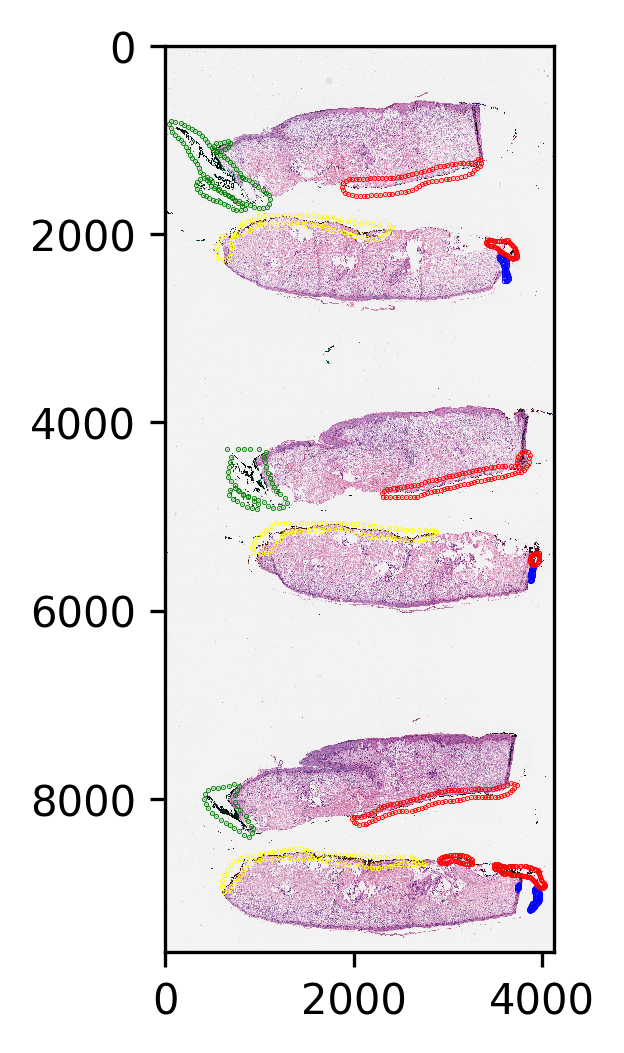

In [72]:
plt.imshow(img)
for i in range(len(contour_df)):
    plt.scatter(*contour_df['contours'].loc[i].T.tolist(),c=contour_df['lbl'].loc[i],s=0.05)

In [1]:
! ls ../*/*/*5_A1eX*

../annotation_checks/FatAnnot_Lou/5_A1eX.xml
../complete/imagenet_embeddings/5_A1eX.pkl
../complete/imagenet_embeddings_256/5_A1eX.pkl
../complete/inputs/5_A1eX.annot.pkl
../complete/inputs/5_A1eX.npy
../complete/inputs/5_A1eX_mask.pkl
../completev2/complete/105_A1eX.0.png
../completev2/complete/105_A1eX.1.png
../completev2/complete/105_A1eX.2.png
../completev2/complete/105_A1eX.3.png
../tissue_quality/practice_images/5_A1eX.pkl


In [73]:
from pathflowai.utils import generate_tissue_mask
from skimage.morphology import label
from skimage import filters

tissue_mask_orig=generate_tissue_mask(img,compression=6,threshold=100,min_object_size=750,kernel=81)


In [74]:
from scipy.ndimage import label as scilabel, distance_transform_edt
# lbl=scilabel(tissue_mask_orig)[0]

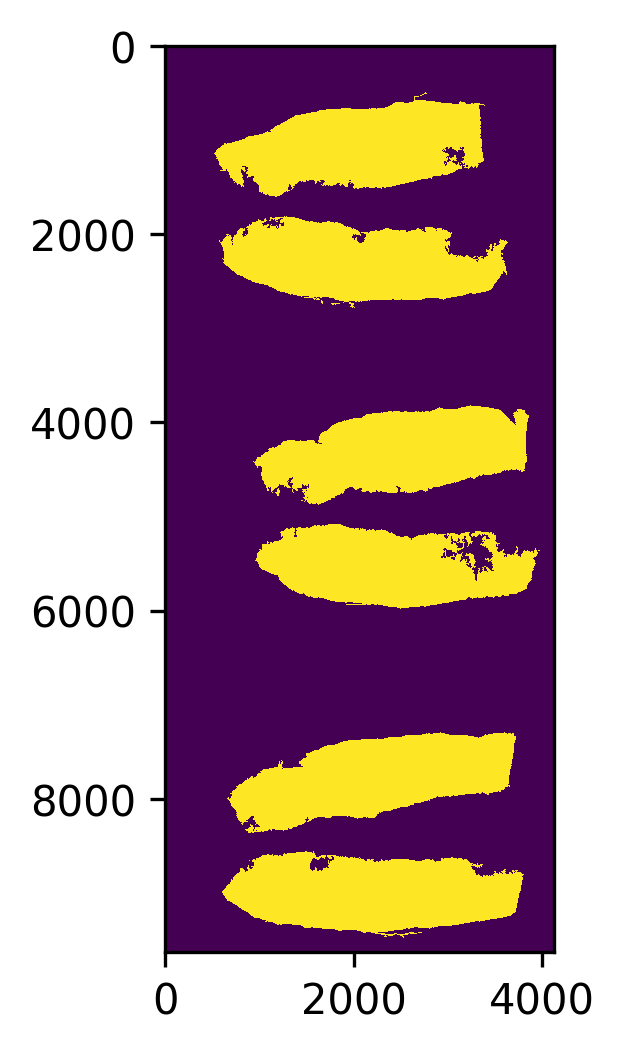

In [75]:
plt.imshow(tissue_mask_orig)

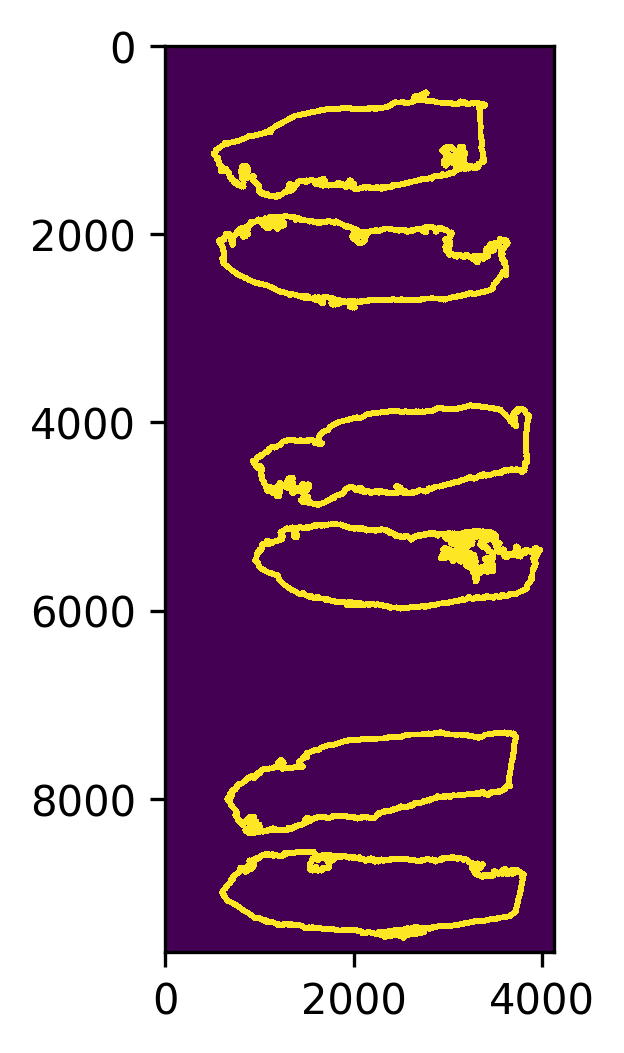

In [76]:
from pathflowai.utils import generate_tissue_mask
from skimage.morphology import disk
from skimage import measure
from scipy.ndimage import binary_opening, binary_dilation
tissue_mask=tissue_mask_orig.copy()
edges = filters.sobel(tissue_mask)>0

edges = binary_dilation(edges,disk(30,bool))#5
plt.imshow(edges)

In [77]:
from skimage import morphology as morph
from scipy.ndimage import label as scilabel
from sklearn.neighbors import radius_neighbors_graph
from scipy.sparse.csgraph import connected_components
import numpy as np, copy
import sys,os
sys.path.insert(0,os.path.abspath('..'))
from filters import filter_red_pen, filter_blue_pen, filter_green_pen

red_img=filter_red_pen(img)
blue_img=filter_blue_pen(img)
green_img=filter_green_pen(img)


arr2=copy.deepcopy(img)
mask=copy.deepcopy(~red_img)
mask=(binary_dilation(mask,disk(3,bool),iterations=5) & edges)#disk(35,bool)
mask=binary_opening(mask,disk(3,bool),iterations=1)
# print(morph.remove_small_objects(mask, min_size=10, connectivity = 5, in_place=True))
red_mask=morph.remove_small_objects(mask, min_size=100, connectivity = 2, in_place=True)>0

arr2=copy.deepcopy(img)
mask=copy.deepcopy(~blue_img)
# mask=(binary_dilation(mask,disk(2,bool)) & edges)#disk(35,bool)
mask=(binary_dilation(mask,disk(3,bool),iterations=5) & edges)#disk(35,bool)
mask=binary_opening(mask,disk(3,bool),iterations=1)
blue_mask=morph.remove_small_objects(mask, min_size=30, connectivity = 2, in_place=True)>0#100

arr2=copy.deepcopy(img)
mask=copy.deepcopy(~green_img)
# mask=(binary_dilation(mask,disk(2,bool)) & edges)#disk(35,bool)
mask=(binary_dilation(mask,disk(3,bool),iterations=5) & edges)#disk(35,bool)
mask=binary_opening(mask,disk(3,bool),iterations=1)
green_mask=morph.remove_small_objects(mask, min_size=30, connectivity = 2, in_place=True)>0#100

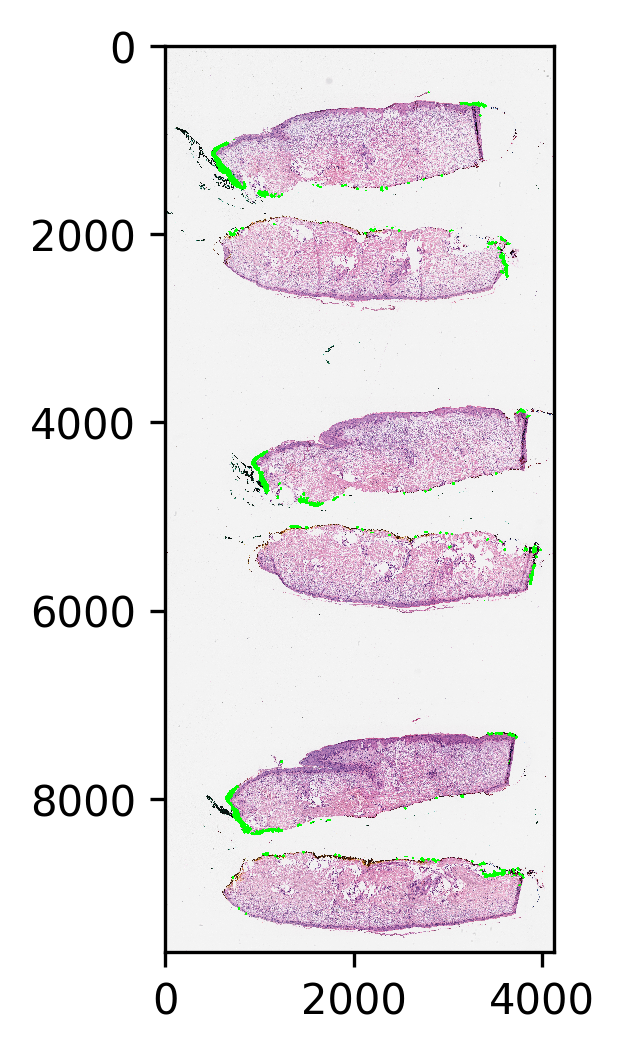

In [78]:
arr2=copy.deepcopy(img)
arr2[green_mask,0]=0
arr2[green_mask,1]=255
arr2[green_mask,2]=0

plt.imshow(arr2)

# plt.imshow(green_mask)

In [79]:
from functools import reduce
# cvScalar(20, 100, 100), cvScalar(30, 255, 255)
def filter_yellow_HSV(img_hsv): # # https://www.learnopencv.com/color-spaces-in-opencv-cpp-python/
    return cv2.inRange(img_hsv,(10, 30, 30), (30, 255, 255) )#return reduce(np.logical_and,([img_lab[...,0]>=20,img_lab[...,0]<=255,
#                   img_lab[...,1]>=110,img_lab[...,1]<=140,
#                   img_lab[...,2]>=150,img_lab[...,2]<=215]))
yellow_img=filter_yellow_HSV(cv2.cvtColor(img, cv2.COLOR_RGB2HSV))
# plt.imshow(yellow_img)
# for i in range(len(contour_df)):
#     if contour_df['lbl'].loc[i]=='yellow':
#         plt.scatter(*contour_df['contours'].loc[i].T.tolist(),c='white',s=0.0005)#contour_df['lbl'].loc[i]

In [80]:
mask=copy.deepcopy(yellow_img)

mask=(binary_dilation(mask,disk(3,bool),iterations=5) & edges)#disk(35,bool)
# plt.imshow(mask)
mask=binary_opening(mask,disk(3,bool),iterations=1)
# print(morph.remove_small_objects(mask, min_size=10, connectivity = 5, in_place=True))
yellow_mask=morph.remove_small_objects(mask, min_size=1000, connectivity = 2, in_place=True)>0
# plt.imshow(yellow_mask)


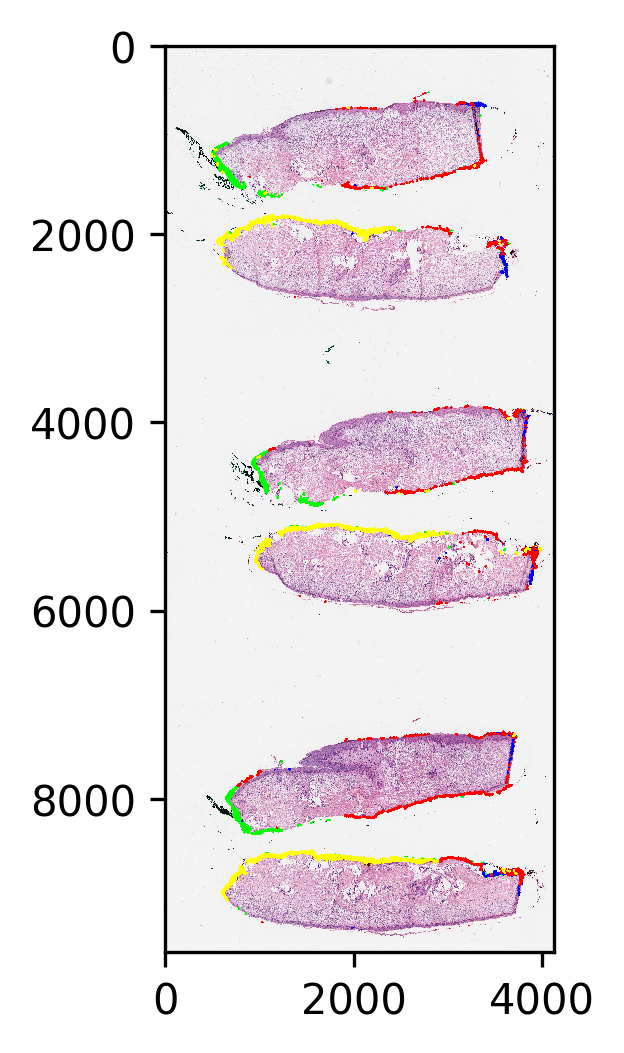

In [81]:
arr2=copy.deepcopy(img)

arr2[green_mask,0]=0
arr2[green_mask,1]=255
arr2[green_mask,2]=0

arr2[blue_mask,0]=0
arr2[blue_mask,1]=0
arr2[blue_mask,2]=255

arr2[red_mask,0]=255
arr2[red_mask,1]=0
arr2[red_mask,2]=0

arr2[yellow_mask,0]=255
arr2[yellow_mask,1]=255
arr2[yellow_mask,2]=0

plt.imshow(arr2)



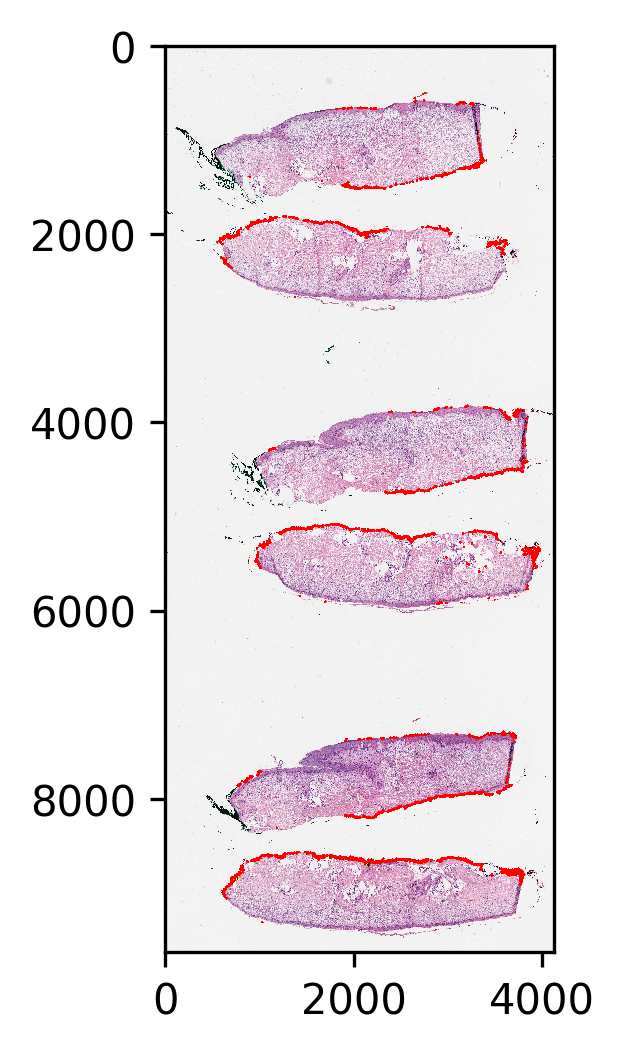

In [82]:
arr2=copy.deepcopy(img)
arr2[red_mask,0]=255
arr2[red_mask,1]=0
arr2[red_mask,2]=0

plt.imshow(arr2)


In [ ]:
# from scipy import ndimage
# slice_x, slice_y = ndimage.find_objects(lbl==4)[0]
# # plt.imshow(tissue_mask[slice_x, slice_y])
# plt.imshow(im[slice_x, slice_y])